DataFrame is a (150 x 4) matrix of iris.csv:

PCA(svd) == PCA(eig) is True


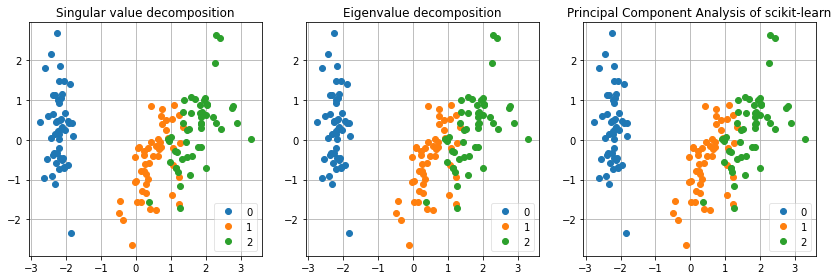

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.datasets

def scale(df, center=True, scale=True):
    ''' compatible with R scale() '''
    if center:
        df = df - df.mean()
    if scale:
        df = df / df.std()
    return df

class PCA:
    def __init__(self, df, npc=2, method='svd'):
        self.df = df
        self.npc = npc
        self.method = method

    def svd(self):
        ''' SVD decomposite X to U*diag(S)*Wt '''
        self.U, self.diagS, self.Wt = np.linalg.svd(self.df, full_matrices=False)

        # singular values are already sorted
        assert np.all(self.diagS[:-1] >= self.diagS[1:]) 

        ''' T = X*W = U*S '''
        pcXW = np.dot(self.df, self.Wt.T[:,:self.npc])
        pcUdS = self.U[:,:self.npc] * self.diagS[:self.npc]
        # these two ways return same results
        assert np.allclose(pcXW, pcUdS)
        self.score = pcUdS

    def eig(self):
        # calculate eigenvalues(l) and eigenvectors(w) of the covariance matrix
        C = np.cov(self.df.T)
        self.l,self.w = np.linalg.eig(C)

        # sort eigenvectors by eigenvalue in descending order
        self.w = self.w[:,np.argsort(self.l)[::-1]]

        ''' T = X*W '''
        self.score = np.dot(self.df, self.w[:,:self.npc])

    def pc(self):
        if self.method == 'svd':
            self.svd()
        else:
            self.eig()
        self.score[:,1] = -self.score[:,1]
        return self.score

def plot(df):
    for name in df['target'].unique():
        cond = df['target'] == name
        plt.plot(df.loc[cond,'PC1'], df.loc[cond,'PC2'], 'o', label=name)
    plt.grid(True)
    plt.legend(framealpha=0.5)

def main():
    np.set_printoptions(precision=4, threshold=30)

    # famous Fisher iris data
    dataset = sklearn.datasets.load_iris()
    df = pd.DataFrame(dataset['data'])
    df.columns = dataset['feature_names']
    df['target'] = dataset['target']

    # use only numerical columns
    values = scale(df.iloc[:,:4], center=True, scale=True)
    print('DataFrame is a (%d x %d) matrix of iris.csv:\n' % (values.shape[0], values.shape[1])) 

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title('Singular value decomposition')
    pca_svd = PCA(values, method='svd')
    score = pd.DataFrame(pca_svd.pc(), columns=['PC1', 'PC2'])
    score = pd.concat([df, score], axis=1)
    plot(score)

    plt.subplot(1,3,2)
    plt.title('Eigenvalue decomposition')
    pca_eig = PCA(values, method='eig')
    score = pd.DataFrame(pca_eig.pc(), columns=['PC1', 'PC2'])
    score = pd.concat([df, score], axis=1)
    plot(score)

    plt.subplot(1,3,3)
    plt.title('Principal Component Analysis of scikit-learn')
    pca_sklearn = sklearn.decomposition.PCA(n_components=2)
    score = pca_sklearn.fit_transform(values)
    score = pd.DataFrame(score, columns=['PC1', 'PC2'])
    score = pd.concat([df, score], axis=1)
    plot(score)

    assert np.allclose(score[['PC1', 'PC2']], pca_svd.pc())

    plt.tight_layout()
    plt.plot()

    # assert two princople components based on SVD and EigenDecomposition
    print('PCA(svd) == PCA(eig) is %s' % np.allclose(pca_svd.pc(), pca_eig.pc()))

if __name__ == '__main__':
    main()

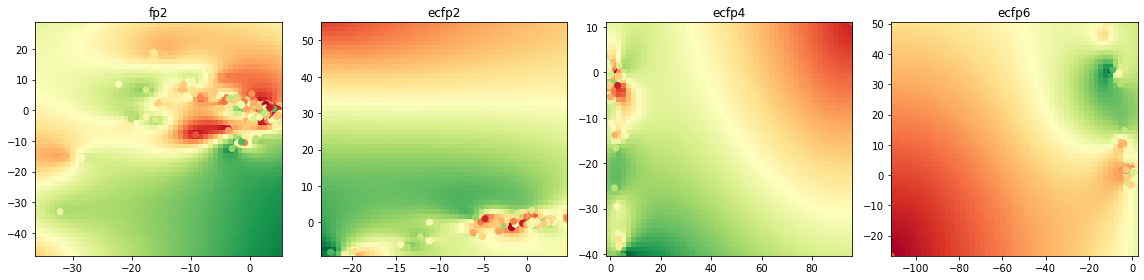

In [21]:
'''
Reference: Peltason L et al.,
Rationalizing three-dimensional activity landscapes and the influence of molecular representations on landscape topology and formation of activity cliffs.,
J Chem Inf Model 50, 1021-1033, 2010.
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
from openbabel import pybel

def scale(X, center=True, scale=True):
    ''' compatible with GNU R scale() '''
    if center:
        X -= X.mean(axis=0)

    if scale:
        std = X.std(axis=0)
        # assign 1. if std is False
        std = np.where(std, std, 1.)
        X /= std
    return X

def pca(X, npc=2):
    # calculate eigenvalues(l) and eigenvectors(w) of the covariance matrix
    C = np.cov(X.T)
    l, w = np.linalg.eig(C)

    # sort eigenvectors by eigenvalue in descending order
    w = w[:,np.argsort(l)[::-1]]
    ''' T = X*W '''
    pc = np.dot(X, w[:,:npc])
    return pc

def fp_mds(fptype, index):
    fps = []
    solubility = []
    for mol in pybel.readfile(filename='data/solubility.test.sdf', format='sdf'):
        fp = mol.calcfp(fptype=fptype).bits
        fps.append(fp)
        solubility.append(np.float32(mol.data['SOL']))

    ncol = max(max(fp) for fp in fps)
    mat = np.zeros((len(fps), ncol+1), dtype=np.float32)
    for i,fp in enumerate(fps):
        mat[i,fp] = 1.

    mat = scale(mat)
    pcs = np.real(pca(mat, npc=2))

    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(pcs[:,0].min(), pcs[:,0].max()), np.linspace(pcs[:,1].min(), pcs[:,1].max())
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(pcs[:,0], pcs[:,1], solubility, function='linear', smooth=0.1)
    zi = rbf(xi, yi)

    plt.subplot(1, 4, index)
    plt.title('%s' % fptype)
    plt.imshow(zi, vmin=zi.min(), vmax=zi.max(), origin='lower', cmap='RdYlGn_r', aspect='auto',
            extent=[pcs[:,0].min(), pcs[:,0].max(), pcs[:,1].min(), pcs[:,1].max()])
    plt.scatter(pcs[:,0], pcs[:,1], c=solubility, cmap='RdYlGn_r')

def main():
    plt.figure(figsize=(16,4))
    for i,fptype in enumerate(['fp2', 'ecfp2', 'ecfp4', 'ecfp6'], 1):
        fp_mds(fptype, i)
    plt.tight_layout()
    plt.plot()

if __name__ == '__main__':
    main()